# High Performance Computing Features

Traditionally, high-performance computing (HPC) and modular software design are at odds.  HPC often demands intricate,
low-level optimizations, making the code hard to understand and modify.  Modularity on the other hand often leads to
sacrificing some performance for the sake of clean, maintainable code.  The design of Pyxu shows that a pragmatic choice
of technologies enables one to obtain a high-performance toolkit without sacrificing flexibility.

## The Conundrum of Performance vs Modularity

Achieving peak performance traditionally meant that you had to write highly specialized, monolithic software,
sacrificing modularity for the sake of computational speed. This is particularly true in High-Performance Computing
(HPC) environments where resources are pushed to their limits. Such software, while incredibly fast, becomes rigid,
harder to maintain, and highly tailored to a specific task. The moment you need to adapt the software to new
requirements or integrate it with other tools, the lack of modularity becomes a bottleneck.

## Why High-Level Programming?
Python, and other high-level languages, offer intrinsic features that facilitate modularity:

* **Easy-to-Read Syntax:**  High-level languages are known for their easy-to-read syntax, and Python is a prime example.
  The language's design encourages writing clean, readable, and therefore, maintainable code (see
  [PEP8](https://peps.python.org/pep-0008/) for example). This readability naturally promotes modular programming and
  collaboration.

* **Rich Libraries:** The extensive collection of libraries in the Python ecosystem reduces the need to write
  boilerplate code, allowing developers to focus on building application-specific modules. The standard libraries
  themselves are highly modular, serving as excellent examples of library design.

* **Foreign Function Interface:** Python's ability to interface with low-level optimized or compiled libraries provides
  a powerful path to achieving high performance while retaining a simple and lean codebase. This opens the door for
  leveraging performance-optimized code without losing Python's inherent advantages.

## Pyxu's Modern Take on HPC

Pyxu is designed around a set of core ideas/technologies to achieve high performance while retaining modularity.
Leveraging state-of-the-art computational technologies from the PyData stack, Pyxu proves that you can indeed have the
best of both worlds. This approach provides the scientific community with a tool that is not just robust and fast, but
also flexible and future-proof.

## High-Performance Computing Features in Pyxu

### Module-Agnostic Infrastructure

Standardized array APIs promote code modularity and portability as you can swap out underlying data structures without
rewriting higher-level code. With the emerging [array-API standard in Python](https://data-apis.org/array-api/latest/)
and platforms such as [Intel's oneAPI](https://www.oneapi.com/), this philosophy is increasingly essential for
interoperable and scalable numerical computing solutions.

The entire Pyxu API is meticulously crafted to be agnostic to the type of arrays being processed: as long as the inputs
abide by the NumPy array API, Pyxu can process them using a single code-base shared amongst compute devices.

This architecture ensures seamless interaction with array libraries such as NumPy, CuPy, and Dask, providing flexibility
and portability.

#### NumPy and Its Siblings: CuPy and Dask

NumPy is the de facto standard for array computing in Python, offering excellent support for a broad range of
mathematical operations.  CuPy and Dask extend NumPy to GPUs and out-of-core and distributed computing, respectively.

#### Embracing GPU Computing with CuPy

Graphical Processing Units (GPUs) have transitioned from graphical renderings to a [broader computational
domain](https://en.wikipedia.org/wiki/General-purpose_computing_on_graphics_processing_units), credited to their ability
to perform parallel operations. For large-scale computations like image processing, GPUs can offer significant
performance enhancements over traditional CPU-centric computations.

#### Distributed and Out-of-core Computing with Dask

[Dask](https://dask.org/) scales Python's eco-system to out-of-core computing, extending the NumPy API to handle
computations that outgrow machine constraints. It does so via lazy computing and chunking:

1. **Lazy Computing**: Instead of immediate computations, Dask builds a computation graph. It then evaluates this graph
   optimally, ensuring resource efficiency.
2. **Chunking**: Dask fragments large arrays into smaller, manageable "chunks", then performs computations on these in
   parallel, optimizing both memory and compute resources.

Leveraging Dask's prowess, Pyxu can execute imaging computations efficiently across multi-core CPUs/GPUs and distributed
computing setups. Dask's scheduler ensures that computational resources are judiciously utilized, streamlining even
complex imaging tasks.

### Vectorization & Just-in-Time Operations

[Vectorization](https://en.wikipedia.org/wiki/Array_programming) denotes the parallel processing of multiple data
elements rather than iterating over them. It's a strategy to exploit data-level parallelism in lieu of task-level
parallelism, a.k.a `SIMD <https://en.wikipedia.org/wiki/Single_instruction,_multiple_data>`_.  Pyxu's operators are
intrinsically vectorized, meaning they are optimized to process stacks of inputs in parallel. This design strategy
significantly enhances efficiency for tasks involving data batches, as frequently seen in imaging.

Similarly, compute-intensive Pyxu operators leverage [Numba](https://numba.pydata.org/) to Just-in-Time (JIT) compile
their codes, side-stepping the Python interpreter entirely. This methodology yields near-native performance, making
Python as performant as statically-typed languages for computational imaging tasks.

### Precision Context Manager

[Compute precision](https://en.wikipedia.org/wiki/Numerical_precision) is a critical aspect of numerical computations,
denoting the exactness or resolution of the computational process. In the world of floating-point arithmetic, higher
precision means more bits representing numbers, which in turn means greater accuracy but at the cost of computational
speed.

Pyxu empowers users to dynamically alter the precision of specific parts of their compute chains, thereby granting more
control over the trade-off between speed and accuracy.

```
import pyxu.runtime as pxrt

op = <some complicated operator>

y = op.apply(x)  # compute in DOUBLE-precision (default)

with pxrt.Precision(pxrt.Width.SINGLE):
    z = op.apply(x)  # compute in SINGLE precision
```

## Hands-on Example:

As an example, consider the following code snippet, defining the median operator:


In [2]:
import pyxu.abc as pxa
import pyxu.util as pxu
import pyxu.runtime as pxrt

class Median(pxa.Func):
    def __init__(self, dim):
        super(Median, self).__init__(shape=(1, dim))

    # Enforce input/output precision.
    @pxrt.enforce_precision(i="arr")
    def apply(self, arr):
        xp = pxu.get_array_module(arr)   # Find the array module.
        return xp.median(arr,            # Dispatch the median call to the right backend.
                         axis=-1,        # Allow for batch dimensions.
                         keepdims=True) 

This operator can then be fed various arrays as inputs:

In [6]:
import time as t
import numpy as np
import pyxu.info.deps as pxd

timings = dict()
dim = 5
m = Median(dim)
for xp in pxd.supported_array_modules():  # Loops over supported array backends
    # Apply the operator in turn on a various array types.
    rng = xp.random.default_rng()
    arr = rng.standard_normal(size=(dim,))
    out = m.apply(arr)
    print(type(out), out.dtype, pxu.compute(out))  # we use compute() to evaluate Dask arrays.

<class 'cupy.ndarray'> float64 [0.15318864]
<class 'dask.array.core.Array'> float64 [1.44176931]
<class 'numpy.ndarray'> float64 [-0.28534482]


If called from within the ``Precision``[🔗](../api/runtime.html#pyxu.runtime.Precision) context manager, the decorated
`apply()` method will automatically coerce the input/output to the user-specified precision:

In [7]:
%%timeit
with pxrt.Precision(pxrt.Width.SINGLE):
    # Single precision is used for the computation
    out = m.apply(np.arange(26*dim).reshape(26, dim))

61.1 µs ± 298 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
%%timeit
with pxrt.Precision(pxrt.Width.DOUBLE):
    # Double precision is used for the computation
    out = m.apply(np.arange(26*dim).reshape(26, dim))  

61.5 µs ± 266 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The support for Dask array inputs also allows to trivially parallelize computations. Consider for example the
hierarchical median operator below:  

In [9]:
class HierarchicalMedian(pxa.Func):
    def __init__(self, dim):
        super().__init__(shape=(1, dim))

    def apply(self, arr):
        xp = pxu.get_array_module(arr)
        
        subs = []
        for i in range(10):
            x = arr[..., 10*i:10*(i+1)]
            y = xp.median(x, axis=-1, keepdims=True)
            subs.append(y)
        y = xp.concatenate(subs, axis=-1)

        z = xp.median(y, axis=-1, keepdims=True)
        return z


There is obviously huge opportunity for parallelism, as shown by the underlying Dask compute graph: 

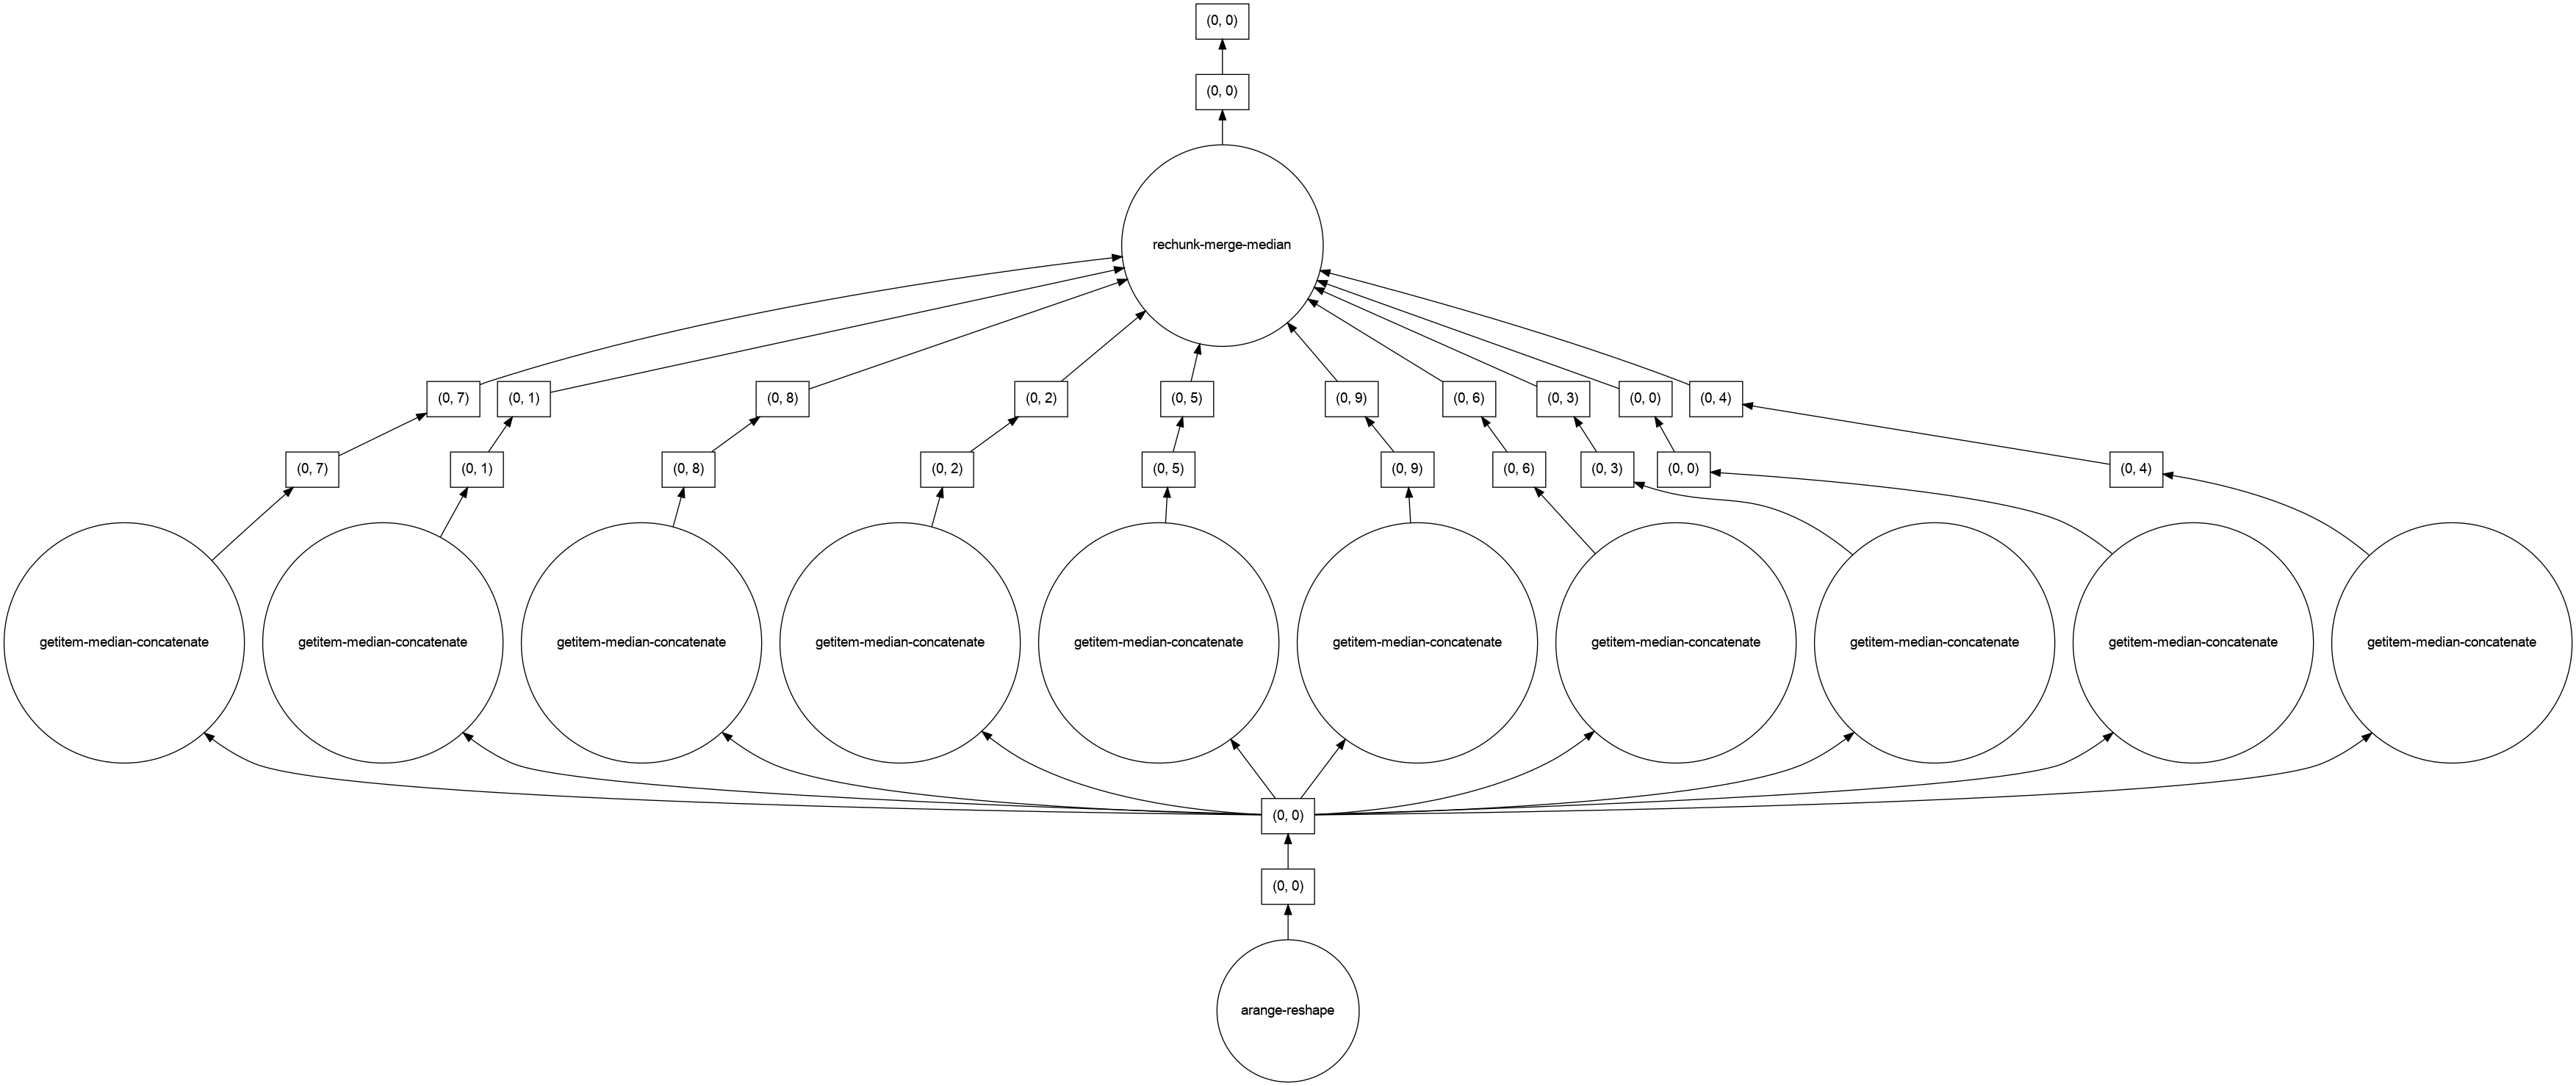

In [11]:
import dask.array as da

dim = 500
hm = HierarchicalMedian(dim)
hm(da.arange(26*dim).reshape(26, dim)).visualize(optimize_graph=True)

Feeding the operator with Dask arrays will automatically distribute the computation for us (note that in this case this
does not provide any speed up):

In [12]:
timings = dict()
for xp in pxd.supported_array_modules():
    t1 = t.time()
    out = pxu.compute(hm.apply(xp.arange(26*dim).reshape(26, dim)))
    timings[xp.__name__] = t.time()-t1
print(timings)    

{'cupy': 0.8727676868438721, 'dask.array': 0.014710187911987305, 'numpy': 0.00039696693420410156}


This is very convenient for the developer, who can focus on the functionality and defer parallelism concerns to Dask. 

## Final Thoughts

Pyxu stands at the intersection of modularity and performance, driven by the power of high-level languages and modern
HPC tools. The array-agnostic nature of its architecture embodies the future of numerical computing—flexible,
interoperable, and performant. With its focus on computational imaging, Pyxu aims to set a benchmark in how we reconcile
ease of use, portability, modularity, and performance in the HPC landscape.

By leveraging Python's features and an array of powerful libraries, Pyxu provides a uniquely modular yet blazingly fast
platform for computational imaging, making it a prime example of how modern software can, indeed, have it all.